In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

show = ToPILImage() #可以将Tensor转成Image

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),#转为Tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))#归一化
])

In [3]:
#训练集
trainset = tv.datasets.CIFAR10(
    root = 'C:/Users/bear/Documents/pyworkspace/pytorch_test/data_set/cifar-10',
    train = True,
    download = False,
    transform = transform
)

trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size = 4,
    shuffle = True,
    num_workers = 2
)

#测试集
testset = tv.datasets.CIFAR10(
    root = 'C:/Users/bear/Documents/pyworkspace/pytorch_test/data_set/cifar-10',
    train = False,
    download = False,
    transform = transform
)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size = 4,
    shuffle = False,
    num_workers = 2
)

truck


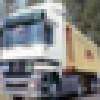

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


(data,label) = trainset[1]
print(classes[label])
show((data + 1) / 2).resize((100,100))


        cat        deer        deer       truck


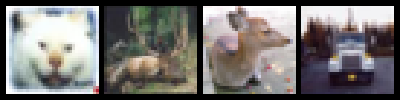

In [5]:
#Dataloader是一个可迭代对象
dataiter = iter(trainloader)
images,labels = dataiter.next()#由于batcch_size=4 ,，因此返回4图像及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

#### 构建网络

In [6]:
class Net(nn.Module):
    def __init__(self):
        #nn.Mudule子类的函数必须在构造函数中执行父类的构造函数
        #下式等价于nn.Module.__init__(self)
        super(Net,self).__init__()
        #1为输入通道数，6为输出通道数，5为卷积核大小
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        #全连接层
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        #reshape 
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### 定义损失函数和优化器

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum = 0.9)


#### 训练网络

In [15]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        #输入数据
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        
        #梯度清零
        optimizer.zero_grad()
        
        #forward + backward
        ouputs = net(inputs)
        loss = criterion(ouputs,labels)
        loss.backward()
        
        #更新参数
        optimizer.step()
        

        #打印log 信息
        running_loss += loss.item()
        if i%2000 == 1999: #每2000个batch打印一次训练状态
            print('[%d,%5d] loss: %.3f' %(epoch+1,i+1,running_loss/2000))
            running_loss = 0.0
            

[1, 2000] loss: 1.249
[1, 4000] loss: 1.239
[1, 6000] loss: 1.238
[1, 8000] loss: 1.205
[1,10000] loss: 1.203
[1,12000] loss: 1.193
[2, 2000] loss: 1.113
[2, 4000] loss: 1.111
[2, 6000] loss: 1.125
[2, 8000] loss: 1.122
[2,10000] loss: 1.141
[2,12000] loss: 1.099


In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))


# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

实际的label:       cat     ship     ship    plane
预测结果:    cat  ship  ship plane


In [19]:
#评估准确率
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 60 %
